## Курсовой проект

### Задача:
##### Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.
### Наименование файлов с данными
##### course_project_train.csv - обучающий датасет
##### course_project_test.csv - тестовый датасет
### Описание датасета
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Импорт модулей

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pylab import rcParams
import seaborn as sns
from scipy.stats import probplot, mannwhitneyu, ttest_rel, boxcox, shapiro, chi2_contingency
    
    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import warnings
warnings.simplefilter('ignore')

### Функции

In [3]:
"""
            ГРАФИКИ
"""
def all_box(data):
    """
    Выведет боксплот для всех числовых признаков
    """
    sns.set(rc={"figure.figsize": (6, 4)})
    float_list = train_df.select_dtypes('float64').columns.tolist()
    for feature in float_list:
        sns.boxplot(data[feature])
        plt.show()
        
        
def hists_descr(feature, bins = 60, log_x = False, log_y = False, grid = False):
    """
    Строит гистограмму и кривую распределения по признаку
    """
    matplotlib.rcParams.update({'font.size' : 8})
    sns.set(rc={"figure.figsize": (12, 4)})
    plt.figure(figsize=(24,6))
    plt.subplot(121)
    feature.hist(bins=bins)
    plt.ylabel('Кол-во наблюдений')
    if log_x:
        plt.xscale(value = 'log')
    if log_y:
        plt.yscale(value = 'log')
    
    plt.subplot(122)
    ax1 = sns.distplot(feature)
    if log_x:
        ax1.set_xscale('log')
    if log_y:
        ax1.set_yscale('log')
    plt.show()
    

def box(num_feature,cat_feature, log_x = False, log_y = False):
    """
    Строит boxplot признака в разрезе целевой переменной
    """
    matplotlib.rcParams.update({'font.size' : 8})
    sns.set(rc={"figure.figsize": (10, 12)})
    target = train_df['Credit Default']
    temp = train_df[f'{cat_feature}'].astype('category')
    sns.boxplot(x = f'{num_feature}', y = temp, hue = target, data = train_df, orient = 'h', palette = 'Set1')
    
def cat_plot(data,feature,x = False, y = False, log_y = False, log_x = False):
    """
    Строит график распределения категориальных признаков в разрезе целевой переменной
    """
    sns.set(rc={"figure.figsize": (12, 4)})
    if x:
        ax = sns.countplot(x = feature, hue = 'Credit Default', data = data)
    if y:
        ax = sns.countplot(y = feature, hue = 'Credit Default', data = data)
    plt.ylabel('Кол-во')
    if log_y:
        ax.set_yscale('log')
    if log_x:
        ax.set_xscale('log')
    plt.show()
    
def plot_kde_qq_interval(data, feature):
    """
    Строит график плотности для признака в разрезе целевой переменной,
    qq диаграмму признака и доверительные интервалы в разрезе целевой переменной
    """
    
    sns.set(rc={"figure.figsize": (18, 12)})
    
    plt.subplot(221)
    sns.kdeplot(data[data['Credit Default'] == 1][feature],label='Погашен', color='green')
    sns.kdeplot(data[data['Credit Default'] == 0][feature],label='Просрочен', color='red')
    plt.xlabel(feature)
    plt.ylabel('Плотность распределения')
    plt.title(f'Распределение {feature} в разрезе целевой переменной')
    
    plt.subplot(222)
    probplot(data[feature].sample(1000), dist='norm', plot=plt)
    plt.title(f'QQ-диаграмма {feature}')
    plt.subplot(223)
    sns.pointplot(x='Credit Default', y=feature, data=data, capsize = .1)
    plt.title(f'Доверительные интервалы {feature}')
    
    plt.show()
    
def plot_qq(data,feature):
    """
    Строит ТОЛЬКО QQ-диаграмму по признаку
    """
    sns.set(rc={"figure.figsize": (10, 6)})
    probplot(data[feature].sample(1000), plot=plt)
    plt.title(f'QQ-диаграмма {feature}')
    plt.show()
    

"""
                ТЕСТЫ
"""    
def shapiro_samples(data, feature, samples_num, bxc = False):
    """
    Проверка распределения на нормальность по критерию Шапиро-Уилка с мощностью семплов 1000
    + обратное преобразование boxcox
    """
    shapiro_l = []
    boxcox_l = []
    for i in range(samples_num):
        spl = data[feature].sample(1000)
        c,p = shapiro(spl)
        shapiro_l.append(p)
        
        if bxc:
            x, y = boxcox(spl)
            c, p = shapiro(x)
            boxcox_l.append(p)
    
    if bxc:
        print(f'Среднее P-value по Shapiro с обратным преобразованием: {sum(boxcox_l)/len(boxcox_l)}')
        print(f'Среднее P-value по Shapiro без обратного преобразования: {sum(shapiro_l)/len(shapiro_l)}')
        print('Установленный нами порог α = 0,05')
    if not bxc:
        print(f'Среднее P-value по Shapiro: {sum(shapiro_l)/len(shapiro_l)}')
        print('Установленный нами порог α = 0,05')
        
def t_student(data, feature, samples_num):
    """
    Нахождение среднего p-value по t-критерию с мощностью семплов 1000
    """

    t_list = []
    for i in range(samples_num):
        spl_0 = data[data['Credit Default']==0][feature].sample(1000)
        spl_1 = data[data['Credit Default']==1][feature].sample(1000)
        
        c,p = ttest_rel(spl_0, spl_1)
        t_list.append(p)
        
    print(f'Среднее p-value по t-критерию Стьюдента равно: {sum(t_list)/len(t_list)}')
    print('Установленный нами порог α = 0,05')
    
    
def manna_uitny(data, feature, samples_num):
    """
    Нахождение среднего p-value по критерию Манна-Уитни с мощностью семплов 1000
    """

    m_list = []
    for i in range(samples_num):
        spl_0 = data[data['Credit Default']==0][feature].sample(1000)
        spl_1 = data[data['Credit Default']==1][feature].sample(1000)
        
        c,p = mannwhitneyu(spl_0, spl_1)
        m_list.append(p)
        
    print(f'Среднее p-value по критерию Манна-Уитни равно: {sum(m_list)/len(m_list)}')
    print('Установленный нами порог α = 0,05')
    
    
def chi2_cat_to_cat(data, feature, samples_num, all_info = False, interest_info = False):
    """
    Сопоставляет категории по chi2
    """
    categories_list_1 = data[feature].unique().tolist()
    categories_list_copy = categories_list_1
    for cat_1 in categories_list_1:
        for cat_2 in categories_list_copy:
            if cat_1 != cat_2:
                
                c_list = []
                p_list = []
                for i in range(samples_num):
                    
                    count_values = data.loc[data[feature] == cat_1, feature].count() + \
                    data.loc[data[feature] == cat_2, feature].count()
                    
                    if count_values < 400:
                        power = count_values
                    else:
                        power = 400
                    
                    spl = data.loc[data[feature].isin([cat_1,cat_2]),['Id',feature,'Credit Default']].sample(power)
                    table = spl.pivot_table(values = 'Id', index = feature, columns = 'Credit Default', aggfunc = 'count')
                    chi2, p, dof, expected = chi2_contingency(table, correction = False)
                    if not np.isnan(chi2):
                        c_list.append(chi2)
                        p_list.append(p)

                if all_info:
                    print(f'{cat_1}    -    {cat_2}')
                    try:
                        c_mean = sum(c_list)/len(c_list)
                        print(f'Среднее chi2 равно: {c_mean}\n' 
                              f'Среднее p-value равно: {sum(p_list)/len(p_list)}')
                        print('Установленный нами порог α = 0,05')
                        print('-'*43)
                    except:
                        print('Недостаточно данных')
                        print('-'*43)
                   
                if interest_info:
                    print('-'*43)
                    print(f'{cat_1}    -    {cat_2}')
                    try:
                        c_mean = sum(c_list)/len(c_list)
                        if c_mean < 0.05:
                            print(f'Среднее chi2 равно: {c_mean}\n' 
                                  f'Среднее p-value равно: {sum(p_list)/len(p_list)}')
                            print('Установленный нами порог α = 0,05')
                            print('-'*43)
                    except:
                        print('Недостаточно данных')
                        print('-'*43)
                        
def low_relevant_features(data):
    """
    Поиск признаков, у которых по меньшей мере 80% строк содержат одно значение
    """
    num_rows = len(data.index)
    low_information_cols = [] #

    for col in data.columns:
        cnts = data[col].value_counts(dropna=False)
        top_pct = (cnts/num_rows).iloc[0]
    
        if top_pct > 0.80:
            low_information_cols.append(col)
            print('{0}: {1:.5f}%'.format(col, top_pct*100))
            print(cnts)
            print()
                        
"""
        ЗАПОЛНЕНИЕ ПРОПУСКОВ, УДАЛЕНИЕ АНОМАЛИЙ
"""                        
                        
def fillna_annual_income(data):
    """
    Заполнение пропусков/аномалий в Annual Income
    """
    scores = train_df['Credit Score'].value_counts().index.to_list()
    for i in scores:
        temp = train_df.loc[train_df['Credit Score'] == i, 'Annual Income']
        train_df.loc[train_df['Annual Income'].isnull() & (train_df['Credit Score'] == i), 'Annual Income'] = temp.median()
    if np.isnan(temp.median()):
        train_df.loc[train_df['Annual Income'].isnull(), 'Annual Income'] = train_df['Annual Income'].median()
"""    for i in scores:
        temp_2 = train_df.loc[train_df['Credit Score'] == i, 'Annual Income']
        train_df.loc[(train_df['Annual Income'] > 9000000) & (train_df['Credit Score'] == i), 'Annual Income'] = temp_2.median()"""
        
"""def fillna_max_open_credit(data):
    if len(data[data['Maximum Open Credit'] == 0]) > 0:
        data.loc[data['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = \
        data.loc[data['Maximum Open Credit'] == 0, 'Current Loan Amount']
    if len(data[data['Maximum Open Credit'] > 9000000]) > 0:
        data.loc[data['Maximum Open Credit'] > 9000000, 'Maximum Open Credit'] = \
        data.loc[data['Maximum Open Credit'] > 9000000, 'Current Loan Amount']
    if len(data[data['Maximum Open Credit'] > 9000000]) > 0:
        data.loc[data['Maximum Open Credit'] > 9000000, 'Maximum Open Credit'] = \
        data['Maximum Open Credit'].median()"""
        
        
def fillna_max_open_credit(data):
    """
    Заполнение пропусков аномалий в Maximum Open Credit
    """
    if len(data[data['Maximum Open Credit'] == 0]) > 0:
        data.loc[data['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = \
        data['Maximum Open Credit'] = data['Maximum Open Credit'].fillna(data['Maximum Open Credit'].median)
"""    if len(data[data['Maximum Open Credit'] > 9000000]) > 0:
        data.loc[data['Maximum Open Credit'] > 9000000, 'Maximum Open Credit'] = \
        data.loc[data['Maximum Open Credit'] > 9000000, 'Current Loan Amount']
    if len(data[data['Maximum Open Credit'] > 9000000]) > 0:
        data.loc[data['Maximum Open Credit'] > 9000000, 'Maximum Open Credit'] = \
        data['Maximum Open Credit'].median()      """  

def fillna_current_loan_amount(data):
    if len(data[data['Current Loan Amount'] >= 99999999]) > 0:
        data.loc[data['Current Loan Amount'] >=99999999, 'Current Loan Amount' ] = \
        data.loc[data['Current Loan Amount'] >=99999999, 'Maximum Open Credit']
        
def fillna_credit_score(data):
    """
    Корректирует значения > 1000, пропуски заменяет медиальным значением
    """
    score_list = data['Credit Score'].to_list()
    credit_list = []
    for i in score_list:
        if i > 1000:
            i = i / 10
            credit_list.append(i)
        else:
            credit_list.append(i)
    data.drop('Credit Score', axis = 1, inplace=True)
    data['Credit Score'] = credit_list
    data['Credit Score'] = data['Credit Score'].fillna(data['Credit Score'].median())
    
def years_cat_to_num(data):
    data.replace({'Years in current job':
                  {'< 1 year': 0,
                   '1 year': 1,
                   '2 years': 2, 
                   '3 years': 3,
                   '4 years': 4,
                   '5 years': 5,
                   '6 years': 6,
                   '7 years': 7,
                   '8 years': 8,
                   '9 years': 9,
                   '10+ years': 10}}, inplace=True)
    
def data_discharge_editor(data):
    """
    Удаляет аномалии по интреквантильному размаху
    """
    #float_list = train_df.select_dtypes('float64').columns.tolist()
    float_list = ['Annual Income','Maximum Open Credit','Current Loan Amount','Current Credit Balance','Monthly Debt']
    for feature in float_list:
        Q1 =  data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        dell = train_df[(data[feature] < Q1-1.5*IQR ) | (data[feature] > Q3+1.5*IQR)].index.tolist()
        data.drop(dell, inplace = True)

### Преобразование дата, добавление столбца Id

In [4]:
train_df = pd.read_csv('course_project_train.csv')
train_df['Id'] = train_df.index.tolist()

## 1.Анализ данных

In [5]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Id
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Id
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733,3749.500000
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874,2165.207842
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000,1874.750000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000,3749.500000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000,5624.250000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000,7499.000000


###  Анализ целевой переменной - Credit Default

In [8]:
# train_df['Credit Default'].isnull().value_counts() # пропусков нет
# train_df[(train_df['Credit Default'] > 1) | (train_df['Credit Default'] < 0)] 
# Целевая переменная не имеет аномальных значений
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Видим, что кол-во выполнения кредитных обязательств значительно превышает кол-во невыполнения

## 2.Предварительный анализ количественных данных и заполнение пропусков

### Первым я обработаю Credit Score по соображениям дальнейшей подгонки относительно него

### 2.0 Credit Score

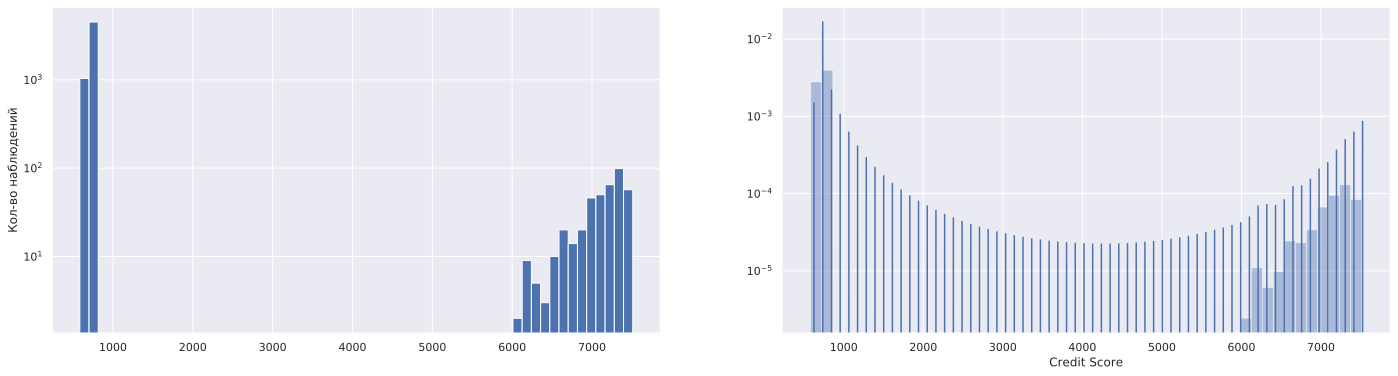

In [9]:
hists_descr(train_df['Credit Score'], log_y=True)

In [10]:
fillna_credit_score(train_df)

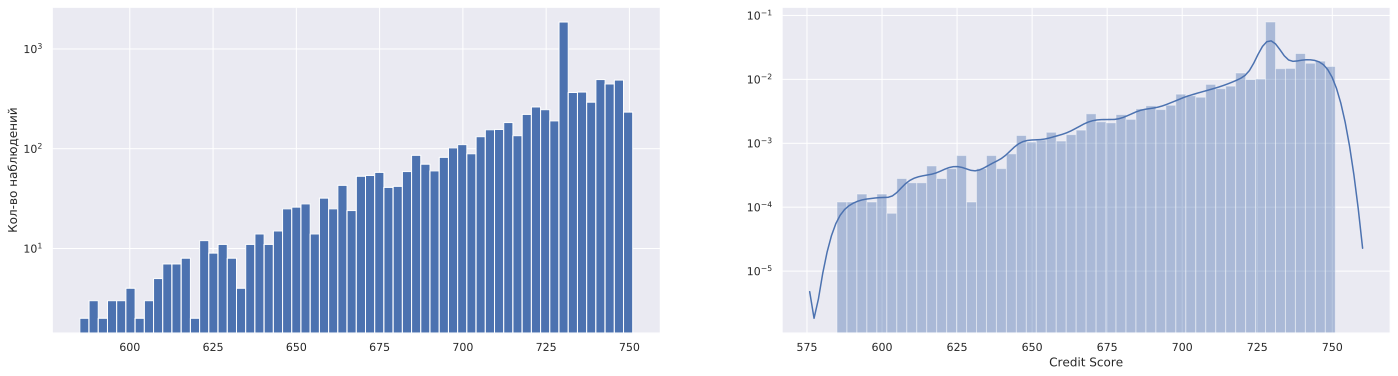

In [11]:
hists_descr(train_df['Credit Score'], log_y=True)

## А вторым я сразу очищу сет от выбросов по расстоянию 3х интерквантильных размахов
### Опытным путем выяснилось, что большинство вышенаписанных функций просто безполезны из-за изначально неверного подхода к обработке данных. Этот дадасет хорошо поддается(из-за хорошего кол-ва наблюдений) нижеуказанной процедуре и убирает практически все изъяны в колличественных данных. И только после удаления выбросов стоит приступать к обработке пропусков.

In [12]:
data_discharge_editor(train_df)

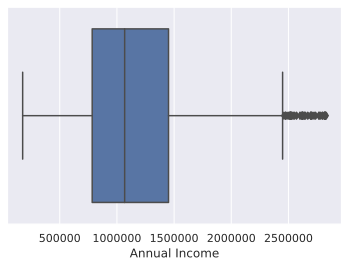

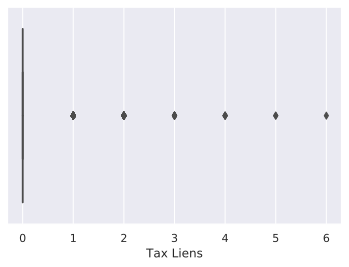

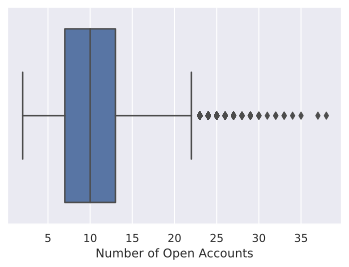

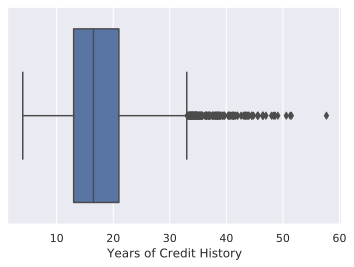

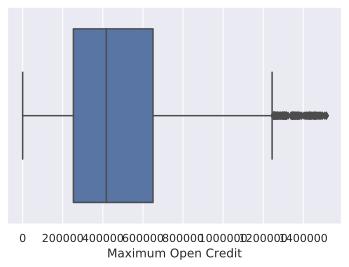

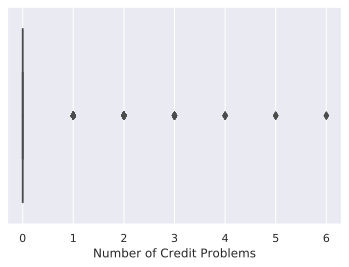

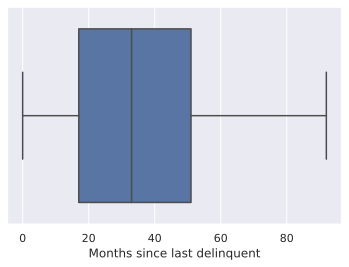

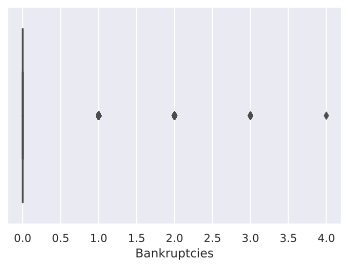

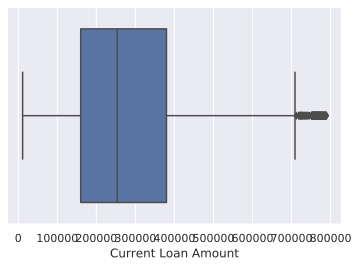

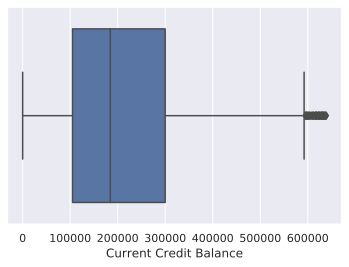

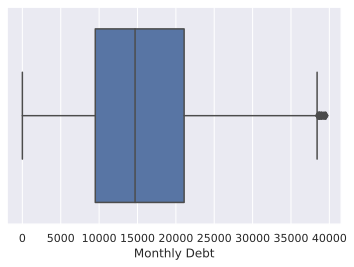

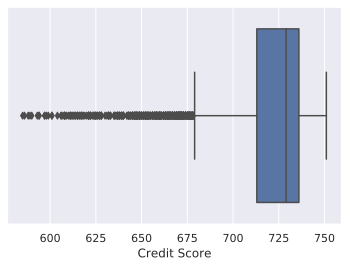

In [13]:
all_box(train_df)

### 2.1.Annual Income

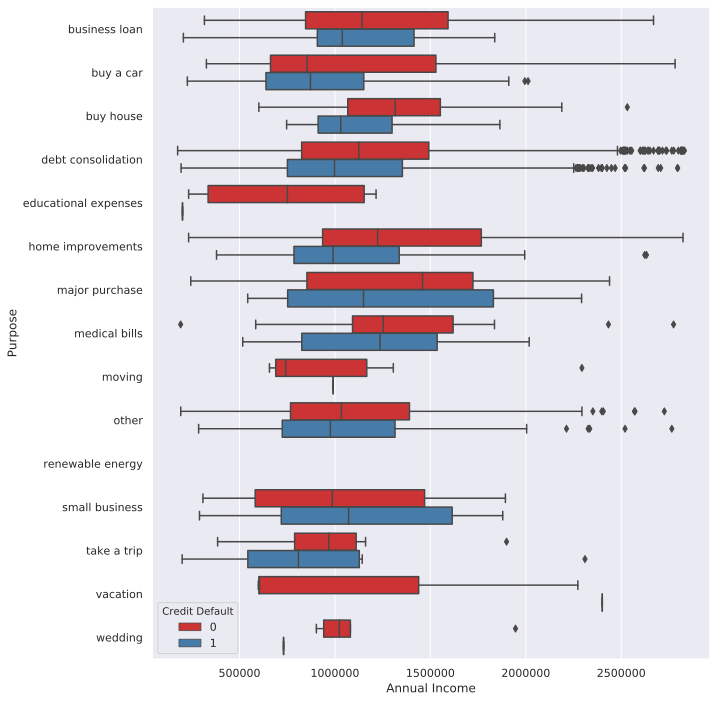

In [14]:
box('Annual Income','Purpose')

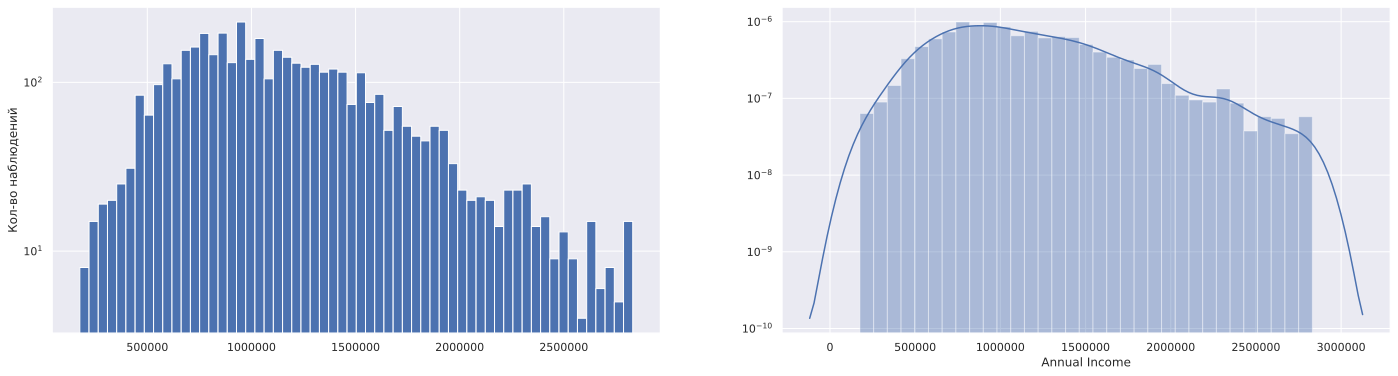

In [15]:
hists_descr(train_df['Annual Income'],log_y = True)

Замена пропусков медиальным значением по кредитному скорингу

In [16]:
fillna_annual_income(train_df)

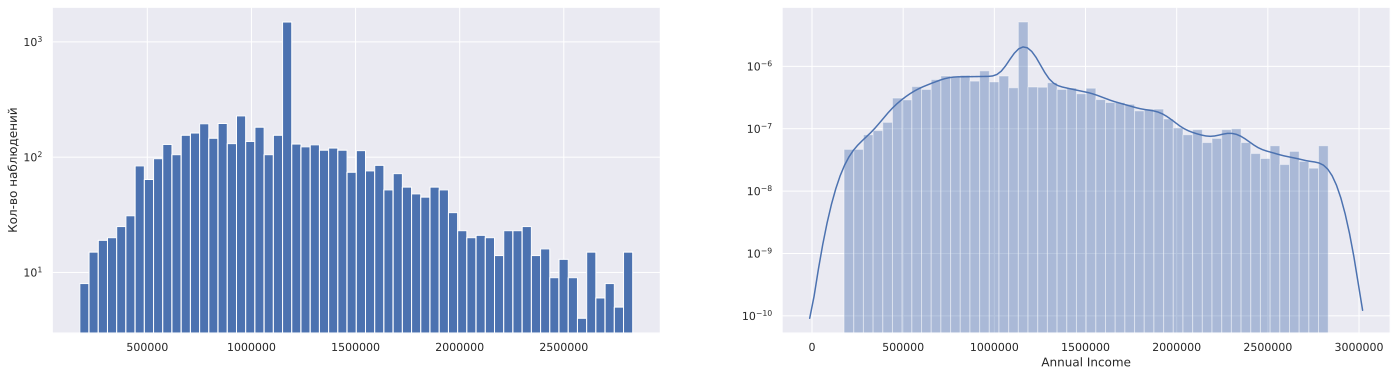

In [17]:
hists_descr(train_df['Annual Income'],log_y = True)

### 2.2.Tax Liens

In [18]:
train_df['Tax Liens'].isnull().value_counts() # пропусков нет
train_df['Tax Liens'].value_counts()

0.0    5558
1.0      58
2.0      22
3.0       8
4.0       4
5.0       2
6.0       1
Name: Tax Liens, dtype: int64

### 2.3.Number of Open Accounts

In [19]:
train_df['Number of Open Accounts'].isnull().value_counts() # пропусков нет
train_df['Number of Open Accounts'].value_counts()

9.0     598
11.0    535
8.0     522
10.0    519
7.0     504
12.0    422
6.0     408
13.0    335
14.0    288
5.0     285
15.0    218
4.0     176
16.0    171
17.0    135
19.0     92
18.0     91
3.0      88
20.0     59
21.0     43
23.0     28
2.0      26
25.0     23
22.0     23
24.0     22
27.0     10
26.0      9
29.0      6
28.0      5
30.0      3
32.0      2
33.0      2
34.0      1
37.0      1
31.0      1
38.0      1
35.0      1
Name: Number of Open Accounts, dtype: int64

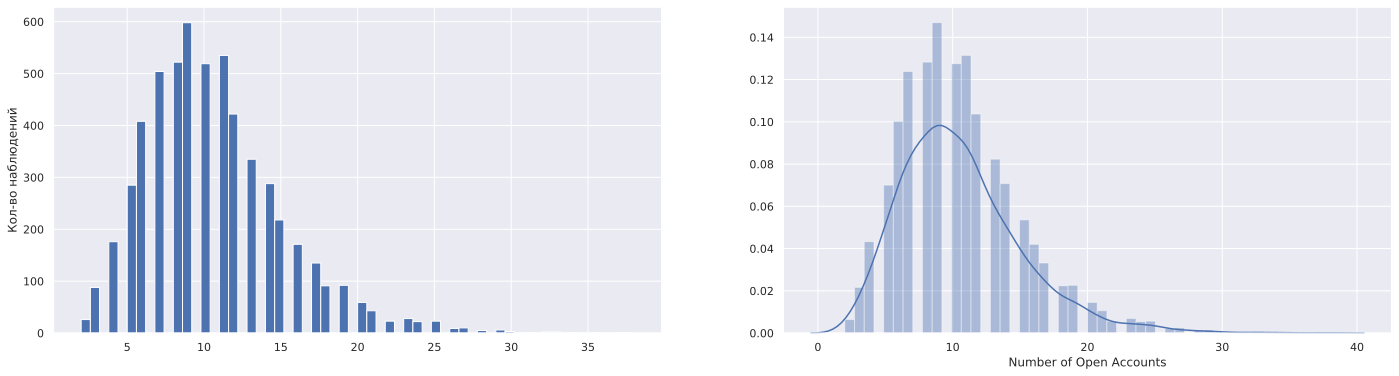

In [20]:
hists_descr(train_df['Number of Open Accounts'])

### 2.4.Years of Credit History

Пропусков нет, аномальных значений нет

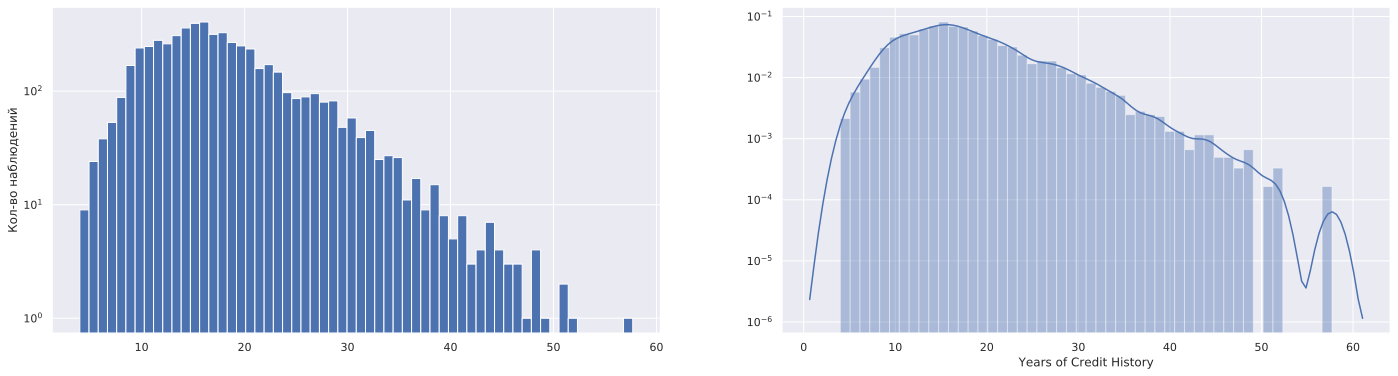

In [21]:
hists_descr(train_df['Years of Credit History'], log_y=True)

### 2.5.Number of Credit Problems

In [22]:
train_df['Number of Credit Problems'].isnull().value_counts() # пропусков нет
train_df['Number of Credit Problems'].value_counts()

0.0    4795
1.0     738
2.0      76
3.0      29
4.0       7
5.0       5
6.0       3
Name: Number of Credit Problems, dtype: int64

### 2.6.Maximum Open Credit

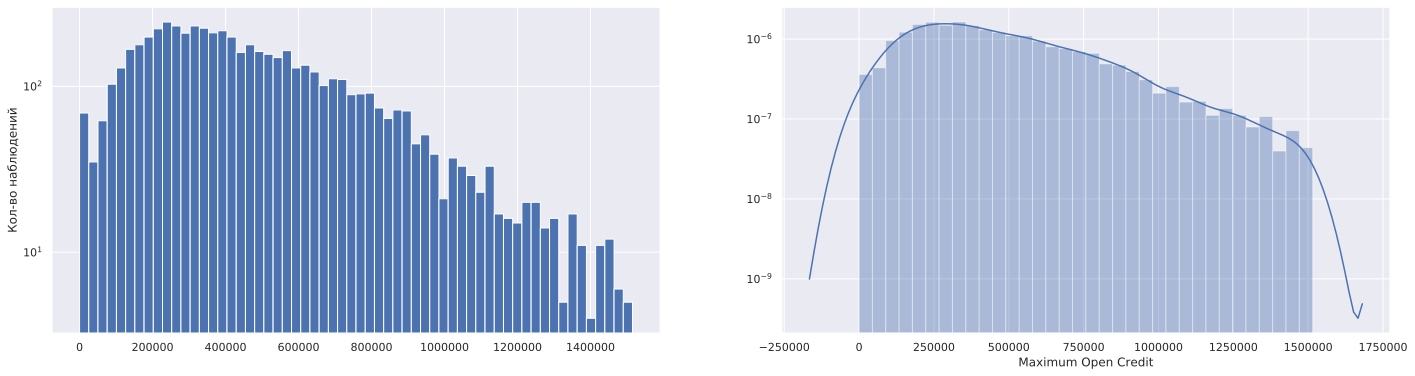

In [23]:
hists_descr(train_df['Maximum Open Credit'], log_y = True)

### 2.7.Months since last delinquent...........UPD(удален)

In [24]:
train_df['Months since last delinquent'].isnull().value_counts()

True     2991
False    2662
Name: Months since last delinquent, dtype: int64

Я не знаю что делать с этим признаком,подчти половина значений пропущенно и он слишком привязан к ситуации конкретного объекта.У меня нет идей как искуственно заменить его. Пока решаю не использовать его при построении модели.

In [25]:
train_df.drop('Months since last delinquent', axis = 1, inplace=True)

### 2.8.Bankruptcies

In [26]:
train_df['Bankruptcies'].isnull().value_counts()

False    5644
True        9
Name: Bankruptcies, dtype: int64

Пропуски заменим на нулевую моду

In [27]:
train_df['Bankruptcies'].mode()[0]

0.0

In [28]:
train_df['Bankruptcies'].fillna(0, inplace=True)

### 2.9.Current Loan Amount

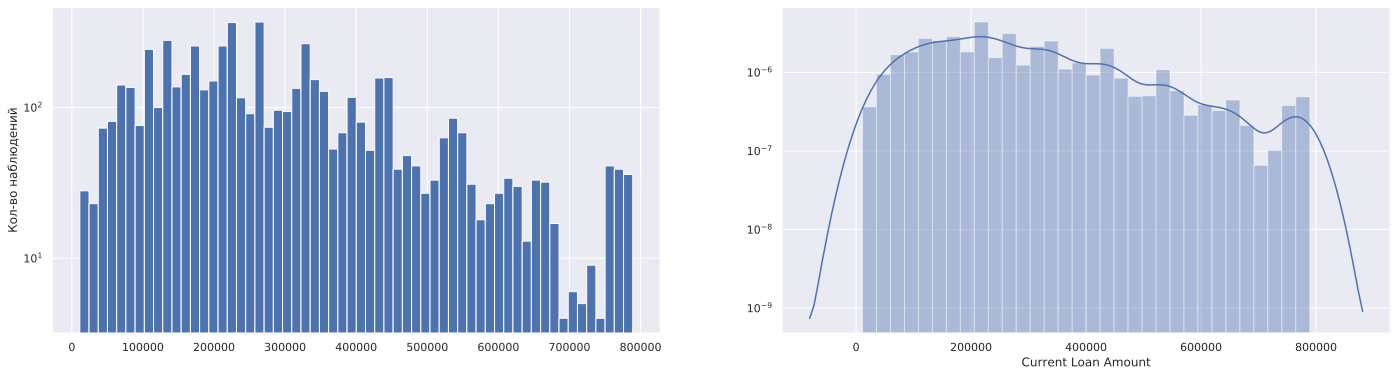

In [29]:
hists_descr(train_df['Current Loan Amount'], log_y=True)

In [30]:
train_df['Current Loan Amount'].describe()

count      5653.000000
mean     284218.840616
std      165044.929157
min       11242.000000
25%      159962.000000
50%      253396.000000
75%      379632.000000
max      789030.000000
Name: Current Loan Amount, dtype: float64

### 2.10.Current Credit Balance

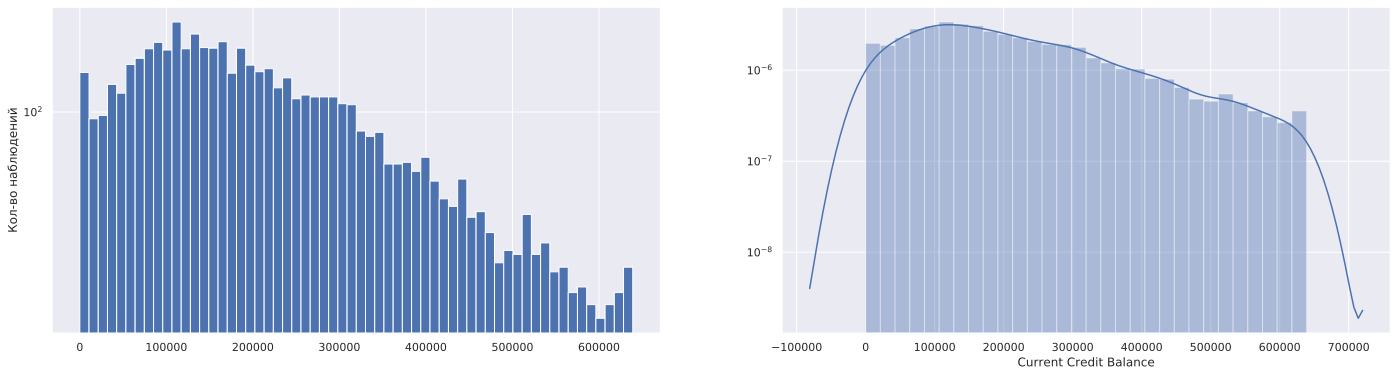

In [31]:
hists_descr(train_df['Current Credit Balance'], log_y=True)

Пропусков и ярких аномалий не замечено

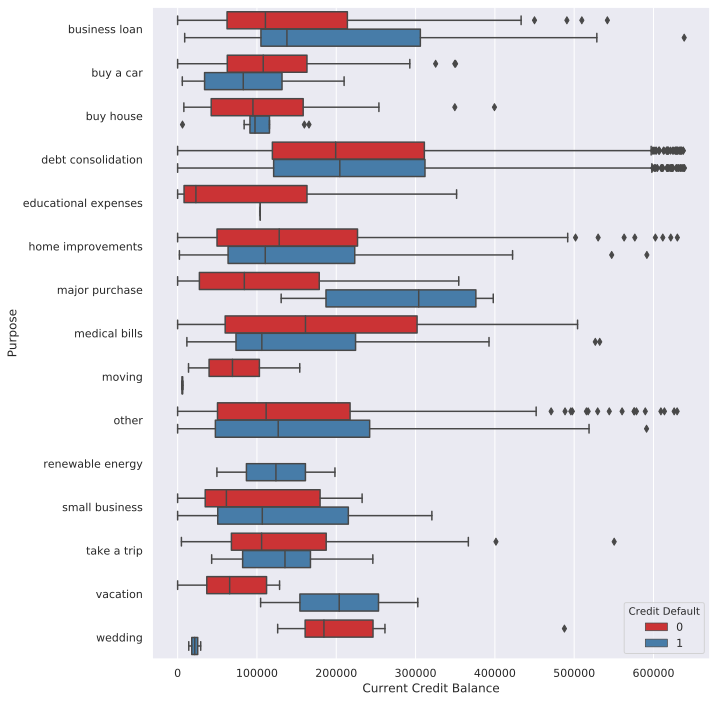

In [32]:
box('Current Credit Balance','Purpose')

### 2.11.Monthly Debt

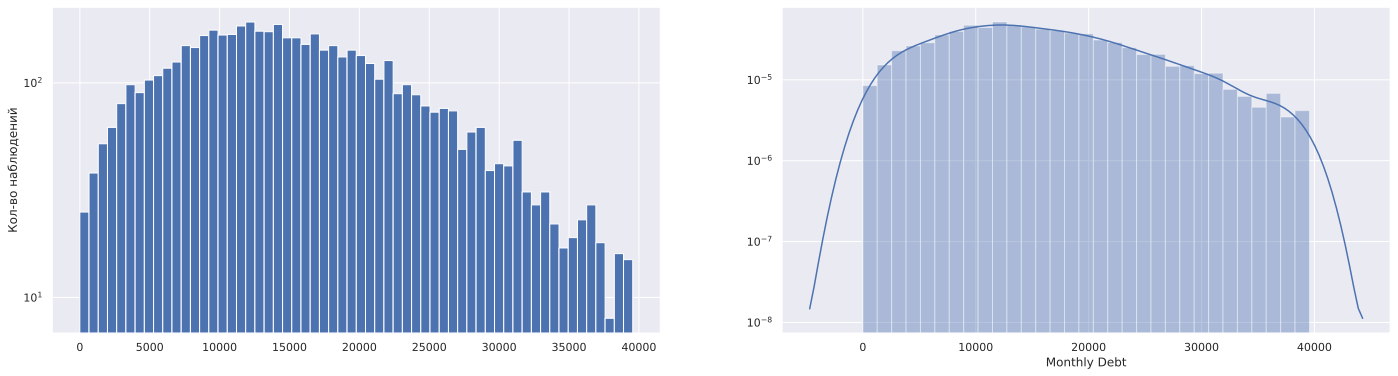

In [33]:
hists_descr(train_df['Monthly Debt'], log_y=True)

Пропусков и очевидных аномалий не замечено

## 3.Предварительный анализ категориальных данных и заполнение пропусков

### 3.1.Home Ownership

In [34]:
train_df['Home Ownership'].isnull().value_counts() # пропусков нет
train_df['Home Ownership'].value_counts()

Rent             2629
Home Mortgage    2535
Own Home          479
Have Mortgage      10
Name: Home Ownership, dtype: int64

### 3.2.Years in current job

In [35]:
train_df['Years in current job'].isnull().value_counts()

False    5365
True      288
Name: Years in current job, dtype: int64

In [36]:
train_df['Years in current job'].mode()

0    10+ years
dtype: object

Заполним пропуски модой

In [37]:
train_df['Years in current job'].fillna('10+ years', inplace=True)

In [38]:
years_cat_to_num(train_df)

### 3.3.Purpose

In [39]:
#train_df['Purpose'].isnull().value_counts()
train_df['Purpose'].value_counts()

debt consolidation      4493
other                    515
home improvements        289
business loan             92
buy a car                 70
medical bills             55
major purchase            32
take a trip               30
buy house                 24
small business            22
wedding                    8
moving                     8
vacation                   7
educational expenses       6
renewable energy           2
Name: Purpose, dtype: int64

Не знаю, что такое возобновляемая энергия. Может это покрытие крыши поликремниевыми батареями(к примеру), можно тогда заменить на home improvements, но замени на моду - debt consolidation.

In [40]:
train_df.loc[train_df['Purpose'] == 'renewable energy', 'Purpose'] = train_df['Purpose'].mode()
train_df['Purpose'].fillna('debt consolidation', inplace=True)

### 3.4.Term

In [41]:
train_df['Term'].value_counts()

Short Term    4192
Long Term     1461
Name: Term, dtype: int64

Пропусков нет

### Посмотрим на корреляционную матрицу

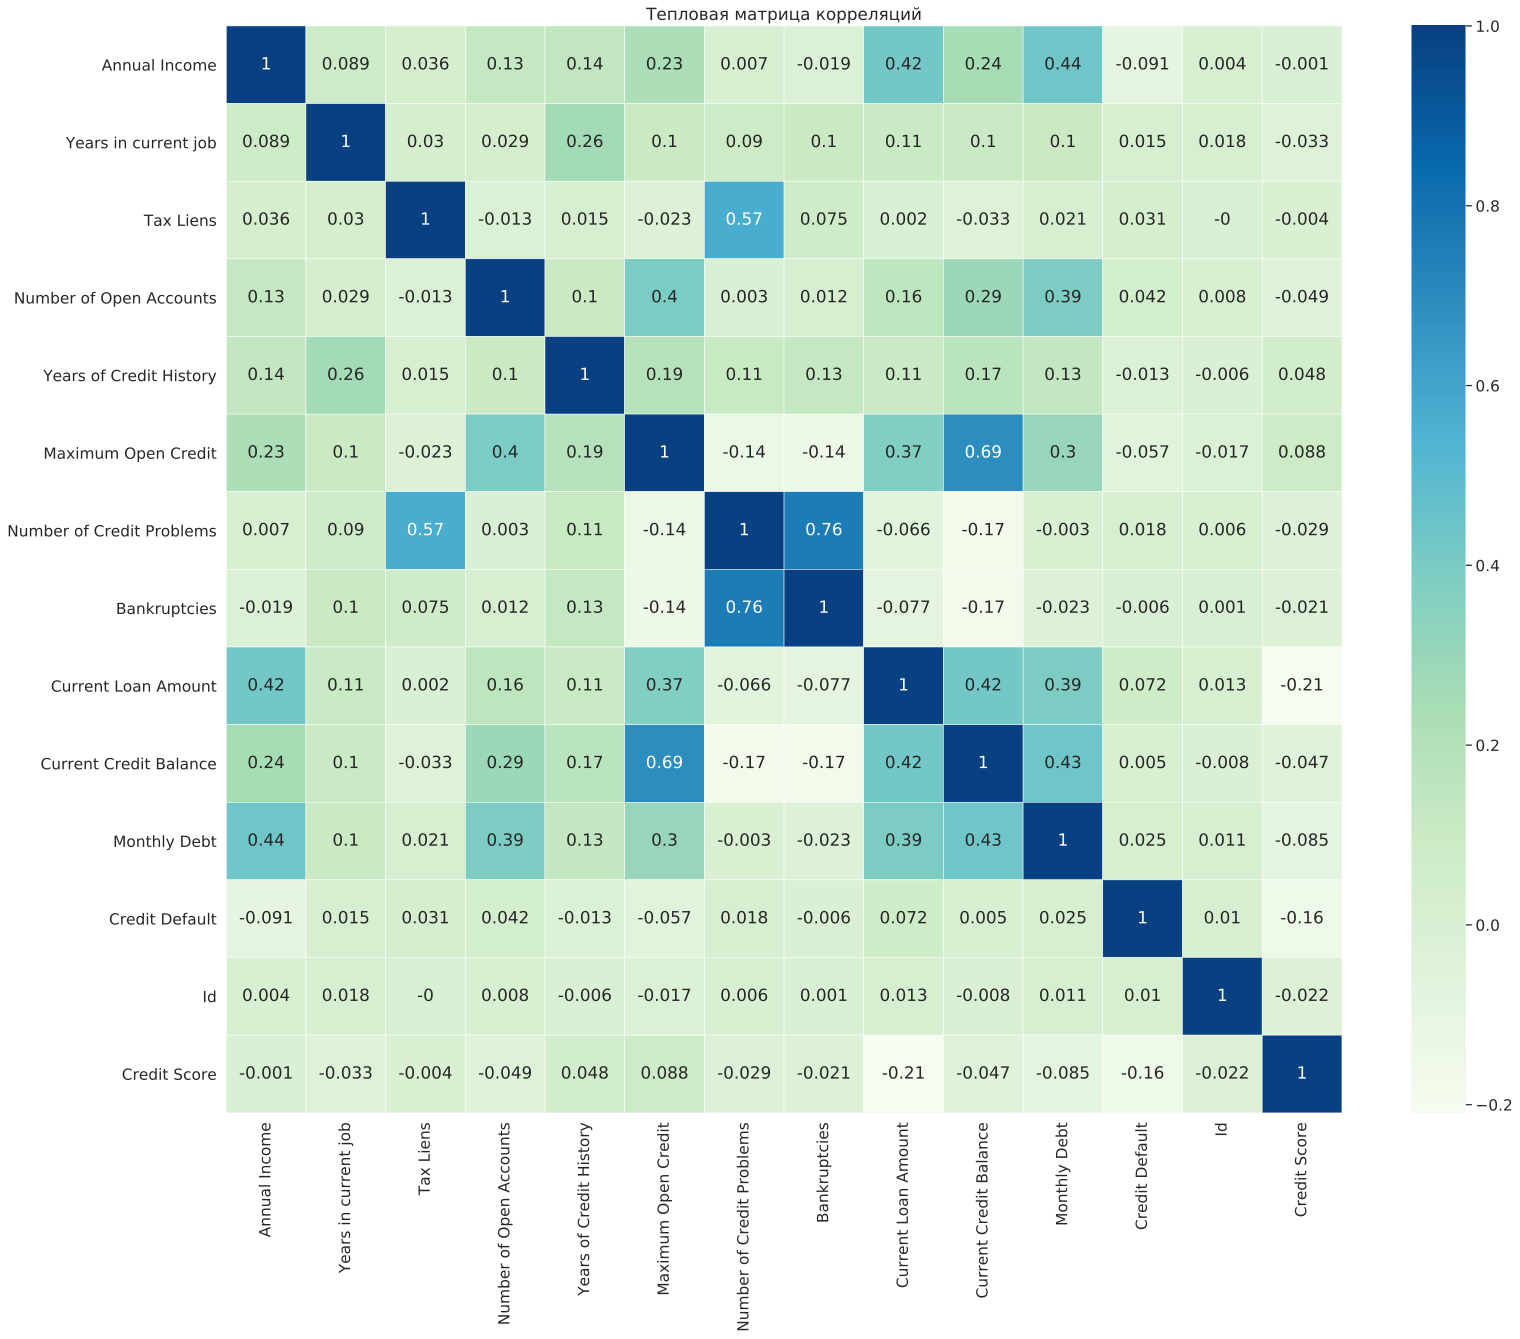

In [42]:
plt.figure(figsize = (25,20))
sns.set(font_scale=1.4)
sns.heatmap(train_df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Тепловая матрица корреляций')
plt.show()

Видим высокую корреляцию между [{Number of Credit Problems : Bankrupties},{Current Credit Balance : Maximum Open Credit}] При проведении подробного анализа стоит присмотреться к этим признакам

## 4.Подробный анализ количественных данных 

### Я так понимаю, что наша основная задача выявить признаки, которые будут вносить весомый вклад в определение целевой переменной, следовательно формирование гипотез будет не как в уроке(нормальное/не нормальное распределение), а полезный/не полезный признак. 

### Исходить будет из разницы распределений относительно целевой переменной, как визуально, так и при помощи критериев Шапиро-Уилка(нормальность распредедения), t-критерий Стьюдента для двух независимых выборок(проверка равенства средних значений) и непараметрическим U критерием Манна-Уитни(для двух независимых выборок)

### Тогда:
* **Нулевая гипотеза H0** - равенство средних значений по Стьюдента/Манна-Уитни равны
* **Альтернативная гипотеза H1** - средние значения не равны и признак полезен для формирования модели
* **Критерии** - Шапиро-Уилка/t-критерий Стьюдента/Непараметрический критерий Манна-Уинти
* **Порог α** - 0,05

### 4.1 Annual Income

In [43]:
#plot_kde_qq_interval(train_df,'Annual Income')

На графиках отчетливо видно, что распределение признака далеко от нормального. НО доверительные интервалы не пересекаются друг с другом, из чего можно предварительно заключить о полезности признака для построения модели. Проведем исследование на нормальность по Шапиро:

In [44]:
shapiro_samples(train_df, 'Annual Income', 30, bxc=True)

Среднее P-value по Shapiro с обратным преобразованием: 2.3806205624307662e-11
Среднее P-value по Shapiro без обратного преобразования: 3.925646577873576e-18
Установленный нами порог α = 0,05


Как и ожидалось, распределение далеко от нормального, применим непараметрический U критерий Манна-Уитни для двух независимых выборок

In [45]:
manna_uitny(train_df, 'Annual Income', 30)

Среднее p-value по критерию Манна-Уитни равно: 5.3530801735190156e-05
Установленный нами порог α = 0,05


#### Выводы:
* **Нулевая гипотеза отвергается, мат.ожидания двух выборок не равны**
* **Признак Annual Income полезен для построения модели**

### 4.2 Number of Open Accounts

In [46]:
#plot_kde_qq_interval(train_df, 'Number of Open Accounts')

Распределение отдаленно похоже на Гауссовское(посмотрм что будет с boxcox). Интервалы совсем немного пересекатся, нулевая и альтернативная гипотезы, как и порог, остаются прежними. Посмотрим на критерий Шапиро-Уилка

In [47]:
shapiro_samples(train_df, 'Number of Open Accounts', 30, bxc=True)

Среднее P-value по Shapiro с обратным преобразованием: 6.0737151731397417e-05
Среднее P-value по Shapiro без обратного преобразования: 8.240017471192708e-18
Установленный нами порог α = 0,05


Распределение далеко от нормального, применяем критерий Манна-Уитни

In [48]:
manna_uitny(train_df, 'Number of Open Accounts', 30)

Среднее p-value по критерию Манна-Уитни равно: 0.08163690638248869
Установленный нами порог α = 0,05


#### Выводы:
* **Нулевая гипотеза принимается**
* **Признак Number of Open Accounts слабо полезен для построения модели**

### 4.3 Years of Credit History

In [49]:
#plot_kde_qq_interval(train_df, 'Years of Credit History')

Распределение далеко от нормального + распредедения в разрезе целевой переменной очень схожи, доверительные интервалы находятся в непосредственной близости. Возможно признак является плохим для построения модели. Посмотрим на Шапиро-Уилка

In [50]:
shapiro_samples(train_df,'Years of Credit History', 30, bxc=True)

Среднее P-value по Shapiro с обратным преобразованием: 0.27566819114920993
Среднее P-value по Shapiro без обратного преобразования: 9.123425545378519e-17
Установленный нами порог α = 0,05


Я делал признак, преобразованный по Боксу-Коксу - он не подходит. 

Помимо этого он каким-то образом добавлял 3 строчки в датасет, в следствие чего моя функция для Хи-квадрат ломалась

In [51]:
manna_uitny(train_df, 'Years of Credit History', 30)

Среднее p-value по критерию Манна-Уитни равно: 0.1974983623672058
Установленный нами порог α = 0,05


#### Выводы:
* **Нулевая гипотеза принимается**
* **Признак Years of Credit History BXC очень слабо полезен для построения модели**
* **Признак Years of Credit History слабо полезен**

### 4.4 Maximum Open Credit

In [52]:
#plot_kde_qq_interval(train_df, 'Maximum Open Credit')

Визуально распределения схожи, при этом похожи на нормальные. Интервалы говорят нам о возможной полезности признака.
Смотрим на Шапиро-Уилка
Преобразование Бокса-Кокса работает только с положительными данными, ОТЛИЧНЫМИ от нуля! А на графике видны нулевые значения признака => не используем преобразование Бокса-Кокса

In [53]:
shapiro_samples(train_df, 'Maximum Open Credit', 30)

Среднее P-value по Shapiro: 4.3444665818316276e-17
Установленный нами порог α = 0,05


In [54]:
manna_uitny(train_df, 'Maximum Open Credit', 30)

Среднее p-value по критерию Манна-Уитни равно: 0.017900076838385917
Установленный нами порог α = 0,05


#### Выводы:
* **Нулевая гипотеза отвергается**
* **Признак Maximum Open Credit полезен для построения модели**

### 4.5 Current Loan Amount

In [55]:
#plot_kde_qq_interval(train_df, 'Current Loan Amount')

In [56]:
shapiro_samples(train_df,'Current Loan Amount',30)

Среднее P-value по Shapiro: 3.9299708582110336e-19
Установленный нами порог α = 0,05


Смотрим на Манна-Уитни

In [57]:
manna_uitny(train_df,'Current Loan Amount', 30)

Среднее p-value по критерию Манна-Уитни равно: 0.004684390491947865
Установленный нами порог α = 0,05


#### Выводы:
* **Нулевая гипотеза отвергается**
* **Признак Current Loan Amount будет полезен для построения модели**

### 4.6 Current Credit Balance

In [58]:
#plot_kde_qq_interval(train_df, 'Current Credit Balance')

In [59]:
shapiro_samples(train_df,'Current Credit Balance', 30)

Среднее P-value по Shapiro: 2.111474579126009e-18
Установленный нами порог α = 0,05


t-критерий Стьюдента:

In [60]:
manna_uitny(train_df,'Current Credit Balance',30)

Среднее p-value по критерию Манна-Уитни равно: 0.22687815341583623
Установленный нами порог α = 0,05


#### Выводы:
* **Нулевая гипотеза принимается**
* **Признак Current Credit Balance не будет полезен для построения модели**

### 4.7 Monthly Debt

In [61]:
#plot_kde_qq_interval(train_df,'Monthly Debt')

In [62]:
shapiro_samples(train_df,'Monthly Debt',30)

Среднее P-value по Shapiro: 3.5627710316098644e-11
Установленный нами порог α = 0,05


In [63]:
manna_uitny(train_df,'Monthly Debt',30)

Среднее p-value по критерию Манна-Уитни равно: 0.12636414475108942
Установленный нами порог α = 0,05


#### Выводы:
* **Нулевая гипотеза принимается**
* **Признак Monthly Debt слабо, но будет полезен для построения модели**

### 4.8 Credit Score

In [64]:
#plot_kde_qq_interval(train_df, 'Credit Score')

Распределение очень далеко от нормального, и главное оно разное. Доверительные интервалы находятся далеко друг от друга.
Смотрим на Шапиро-Уилка

In [65]:
shapiro_samples(train_df,'Credit Score',30)

Среднее P-value по Shapiro: 3.178213334877706e-32
Установленный нами порог α = 0,05


Смотрим на Манна-Уитни

In [66]:
manna_uitny(train_df,'Credit Score',30)

Среднее p-value по критерию Манна-Уитни равно: 7.601157537501972e-10
Установленный нами порог α = 0,05


Один из самых полезных критериев, что логично

#### Выводы:
* **Нулевая гипотеза отвергается**
* **Признак Credit Score очень полезен для построения модели**

### 4.9 Bankruptcies

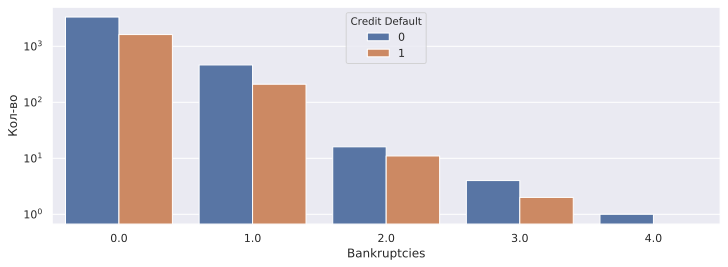

In [67]:
cat_plot(train_df,'Bankruptcies', x=True, log_y=True)

In [68]:
chi2_cat_to_cat(train_df, 'Bankruptcies', 30, all_info = True)

0.0    -    1.0
Среднее chi2 равно: 1.0088948085235545
Среднее p-value равно: 0.528551565909583
Установленный нами порог α = 0,05
-------------------------------------------
0.0    -    3.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
0.0    -    2.0
Среднее chi2 равно: 0.24514731854031283
Среднее p-value равно: 0.7125564055165347
Установленный нами порог α = 0,05
-------------------------------------------
0.0    -    4.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
1.0    -    0.0
Среднее chi2 равно: 0.976431487810886
Среднее p-value равно: 0.4679421604612245
Установленный нами порог α = 0,05
-------------------------------------------
1.0    -    3.0
Среднее chi2 равно: 0.3808793510823213
Среднее p-value равно: 0.6311729719489136
Установленный нами порог α = 0,05
-------------------------------------------
1.0    -   

Частоты согласованы.

По поводу 4 - слишком мало значений для анализа. Пока пробую оставить признак как есть

### Обзор колличественных признаков по результатам анализа:


#### Полезные признаки:
* **Annual Income**
* **Credit Score**
* **Maximum Open Credit**
* **Current Loan Amount**
* **Number of Open Accounts**
* **Credit Score**


#### Спорные(?) признаки:

* **Years of Credit History**
* **Current Credit Balance**
* **Monthly Debt**

## 5 Подробный анализ категориальных данных 

* **Нулевая гипотеза H0** - частоты согласованы
* **Альтернативная гипотеза H1** - отклонения в частотах сильно различаются
* **Критерии** - Хи-квадрат Пирсона
* **Порог α** - 0,05

### 5.1 Home Ownership

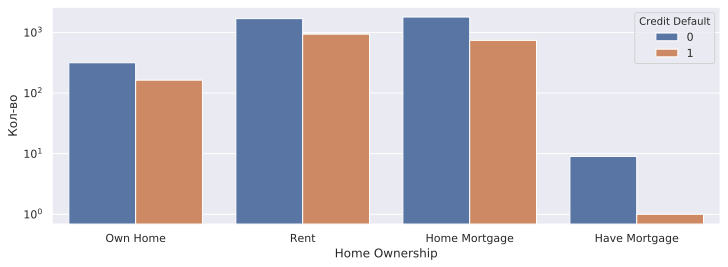

In [69]:
cat_plot(train_df,'Home Ownership', x=True, log_y=True)

Исходя из графика можно предположить, что все категории имеют похожее частотное распределение в разрезе целелвой переменной.
Проверим предположение с помощью критерия Пирсона

In [70]:
chi2_cat_to_cat(train_df, 'Home Ownership', 30, all_info = True)

Own Home    -    Rent
Среднее chi2 равно: 0.7486575997127088
Среднее p-value равно: 0.49236192794198463
Установленный нами порог α = 0,05
-------------------------------------------
Own Home    -    Home Mortgage
Среднее chi2 равно: 1.2108195371938966
Среднее p-value равно: 0.5274632824017091
Установленный нами порог α = 0,05
-------------------------------------------
Own Home    -    Have Mortgage
Среднее chi2 равно: 1.7836316184433467
Среднее p-value равно: 0.1935216358765521
Установленный нами порог α = 0,05
-------------------------------------------
Rent    -    Own Home
Среднее chi2 равно: 0.8414057005385757
Среднее p-value равно: 0.5427350261887925
Установленный нами порог α = 0,05
-------------------------------------------
Rent    -    Home Mortgage
Среднее chi2 равно: 2.2639746428661005
Среднее p-value равно: 0.3001762947338056
Установленный нами порог α = 0,05
-------------------------------------------
Rent    -    Have Mortgage
Среднее chi2 равно: 0.026125127344504277
Сре

#### Выводы:
* **Нулевая гипотеза принимается для Own Home, Home Mortgage, Rent**
* **Нулевая гипотеза сомнительна применима для Have Mortgage**

### 5.2 Years in current job

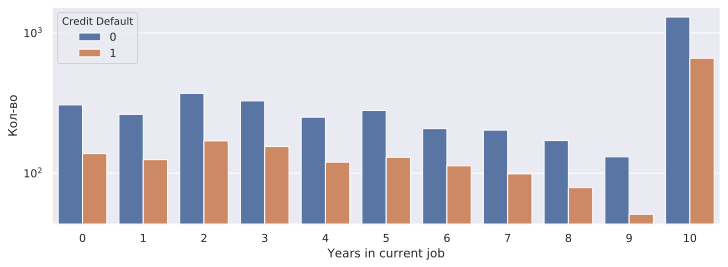

In [71]:
cat_plot(train_df,'Years in current job', x=True, log_y=True)

Определенно есть категории, частоты которых совпадают и их можно будет объединить.
Посмотрим, что покажет критерий Пирсона.

P.S. Там будет большой список, я все опишу в выводах по признаку

In [72]:
chi2_cat_to_cat(train_df,'Years in current job',30, all_info = True)

10    -    6
Среднее chi2 равно: 0.9236748877006579
Среднее p-value равно: 0.5591744960867054
Установленный нами порог α = 0,05
-------------------------------------------
10    -    8
Среднее chi2 равно: 0.6284125377495968
Среднее p-value равно: 0.6003800837779741
Установленный нами порог α = 0,05
-------------------------------------------
10    -    7
Среднее chi2 равно: 0.6385323070753851
Среднее p-value равно: 0.6101513927716796
Установленный нами порог α = 0,05
-------------------------------------------
10    -    5
Среднее chi2 равно: 0.9051465032367313
Среднее p-value равно: 0.49817081018374865
Установленный нами порог α = 0,05
-------------------------------------------
10    -    1
Среднее chi2 равно: 1.0865759984637868
Среднее p-value равно: 0.4593072833031506
Установленный нами порог α = 0,05
-------------------------------------------
10    -    0
Среднее chi2 равно: 0.8500009428681129
Среднее p-value равно: 0.48446662925784223
Установленный нами порог α = 0,05
----------

5    -    3
Среднее chi2 равно: 0.6031224486562636
Среднее p-value равно: 0.5660357574836242
Установленный нами порог α = 0,05
-------------------------------------------
5    -    9
Среднее chi2 равно: 0.6959512427171287
Среднее p-value равно: 0.521105025253047
Установленный нами порог α = 0,05
-------------------------------------------
1    -    10
Среднее chi2 равно: 1.032732284788232
Среднее p-value равно: 0.5416345704033908
Установленный нами порог α = 0,05
-------------------------------------------
1    -    6
Среднее chi2 равно: 0.8520981438807567
Среднее p-value равно: 0.4902082427214794
Установленный нами порог α = 0,05
-------------------------------------------
1    -    8
Среднее chi2 равно: 0.3221024174320465
Среднее p-value равно: 0.6663800905055385
Установленный нами порог α = 0,05
-------------------------------------------
1    -    7
Среднее chi2 равно: 0.5783369610900532
Среднее p-value равно: 0.5458805475620456
Установленный нами порог α = 0,05
-------------------

3    -    0
Среднее chi2 равно: 0.7072323254832025
Среднее p-value равно: 0.5200630275327698
Установленный нами порог α = 0,05
-------------------------------------------
3    -    4
Среднее chi2 равно: 0.37536434334276714
Среднее p-value равно: 0.6634916341299626
Установленный нами порог α = 0,05
-------------------------------------------
3    -    2
Среднее chi2 равно: 0.3651877773725512
Среднее p-value равно: 0.6732657599109085
Установленный нами порог α = 0,05
-------------------------------------------
3    -    9
Среднее chi2 равно: 1.1284904931535449
Среднее p-value равно: 0.44412547960222976
Установленный нами порог α = 0,05
-------------------------------------------
9    -    10
Среднее chi2 равно: 0.9732334372777357
Среднее p-value равно: 0.4965369841855866
Установленный нами порог α = 0,05
-------------------------------------------
9    -    6
Среднее chi2 равно: 2.376398147328856
Среднее p-value равно: 0.16182517134359406
Установленный нами порог α = 0,05
---------------

Удивительно, но

9 years    -    10+ years

Среднее chi2 равно: 1.0703448634117891

Среднее p-value равно: 0.4733160495111168

Установленный нами порог α = 0,05

Чего не скажешь по графику. Может я где-то ошибся в функции?

#### Выводы:
* **Нулевая гипотеза принимается для всех категорий**
* **Альтернативная гипотеза отвергается**

### 5.3 Purpose

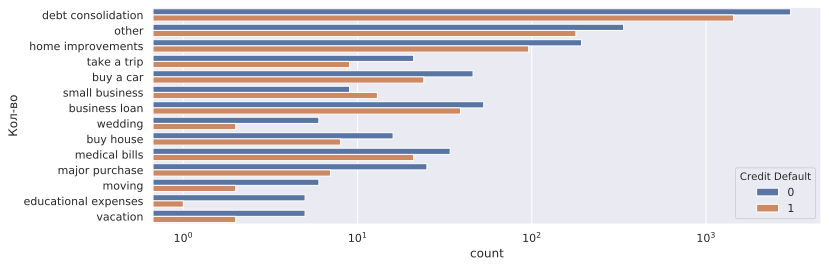

In [73]:
cat_plot(train_df,'Purpose', y = True, log_x = True)

In [74]:
# interest_info выводит данные только тех пар, где chi2 < 0.05
chi2_cat_to_cat(train_df,'Purpose',30, interest_info = True)

-------------------------------------------
debt consolidation    -    other
-------------------------------------------
debt consolidation    -    home improvements
-------------------------------------------
debt consolidation    -    take a trip
-------------------------------------------
debt consolidation    -    buy a car
-------------------------------------------
debt consolidation    -    small business
-------------------------------------------
debt consolidation    -    business loan
-------------------------------------------
debt consolidation    -    wedding
Среднее chi2 равно: 0.004609554261516346
Среднее p-value равно: 0.984372844254151
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
debt consolidation    -    buy house
-------------------------------------------
debt consolidation    -    medical bills
-------------------------------------------
debt consolidation    -    major purchase
--------

-------------------------------------------
wedding    -    debt consolidation
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
wedding    -    other
-------------------------------------------
wedding    -    home improvements
-------------------------------------------
wedding    -    take a trip
-------------------------------------------
wedding    -    buy a car
-------------------------------------------
wedding    -    small business
-------------------------------------------
wedding    -    business loan
-------------------------------------------
wedding    -    buy house
-------------------------------------------
wedding    -    medical bills
-------------------------------------------
wedding    -    major purchase
Среднее chi2 равно: 0.03584229390681003
Среднее p-value равно: 0.8498415418597329
Установленный нами порог α = 0,05
----------------------

-------------------------------------------
vacation    -    other
-------------------------------------------
vacation    -    home improvements
-------------------------------------------
vacation    -    take a trip
Среднее chi2 равно: 0.005544455544455529
Среднее p-value равно: 0.9406434922074026
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
vacation    -    buy a car
-------------------------------------------
vacation    -    small business
-------------------------------------------
vacation    -    business loan
-------------------------------------------
vacation    -    wedding
Среднее chi2 равно: 0.024350649350649376
Среднее p-value равно: 0.8759960169024941
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
vacation    -    buy house
-------------------------------------------
vacation    -    medical bills
----------------------

Имеем такой список:
* debt consolidation    -    educational expenses
* debt consolidation    -    vacation
* home improvements    -    vacation
* take a trip    -    wedding
* take a trip    -    buy house
* take a trip    -    vacation
* buy a car    -    wedding
* buy a car    -    buy house
* buy a car    -    vacation
* wedding    -    take a trip
* wedding    -    buy a car
* wedding    -    buy house
* wedding    -    vacation
* educational expenses    -    debt consolidation
* buy house    -    take a trip
* buy house    -    buy a car
* buy house    -    wedding
* buy house    -    vacation
* major purchase    -    vacation
* vacation    -    debt consolidation
* vacation    -    home improvements
* vacation    -    take a trip
* vacation    -    buy a car
* vacation    -    wedding
* vacation    -    buy house
* vacation    -    major purchase


После разбора сложилось мнение, что этот признак можно разделить на 3 бинарных:
#### 1:
* debt consolidation
* other
* home improvements
* take a trip
* buy a car
* small business
* business loan
* medical bills
* major purchase

#### 2:
* vacation
* educational expenses
* moving
* buy house 

#### 3:
* Wedding

#### Выводы:
* **Нулевая гипотеза принимается для категорий по 3м бинарным признакам(списки выше)**
* **Альтернативная гипотеза отвергается**

### 5.4 Term

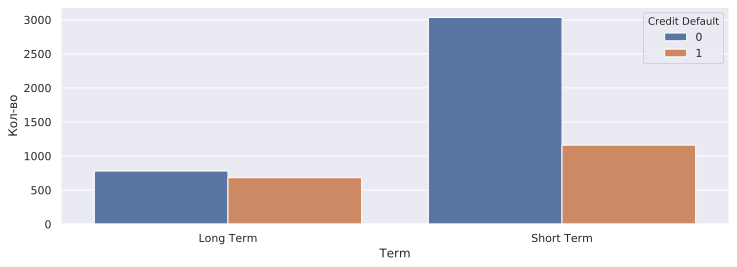

In [75]:
cat_plot(train_df,'Term',x = True)

In [76]:
chi2_cat_to_cat(train_df,'Term',30, all_info = True)

Long Term    -    Short Term
Среднее chi2 равно: 14.492851950013009
Среднее p-value равно: 0.021381027443878417
Установленный нами порог α = 0,05
-------------------------------------------
Short Term    -    Long Term
Среднее chi2 равно: 14.323529433186394
Среднее p-value равно: 0.004105305534173913
Установленный нами порог α = 0,05
-------------------------------------------


#### Выводы:
* **Нулевая гипотеза отвергается**
* **Признак выглядит полезным для модели**

### 5.5 Tax Liens

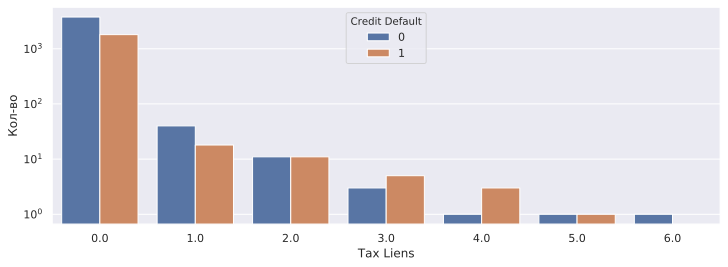

In [77]:
cat_plot(train_df,'Tax Liens', x = True, log_y = True)

In [78]:
chi2_cat_to_cat(train_df,'Tax Liens',30, interest_info=True)

-------------------------------------------
0.0    -    3.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
0.0    -    1.0
-------------------------------------------
0.0    -    2.0
-------------------------------------------
0.0    -    4.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
0.0    -    5.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
0.0    -    6.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
3.0    -    0.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный

Не хватает данных для полной уверенности в оценке данного признака, может быть есть смысл преобразовать 0-5 и 6-7 в 2 бинарных признака?

Также логика мне подсказывает, что признак довольно важен, что мы видим по p-value.

Пока не буду делать преобразование для данного признака, пусть пока послужит нам как числовой

#### Выводы:
* **Нулевая гипотеза принимается для критериев 0-5**
* **Альтернативная гипотеза принимается для критериев 6-7**

### 5.6 Number of Credit Problems

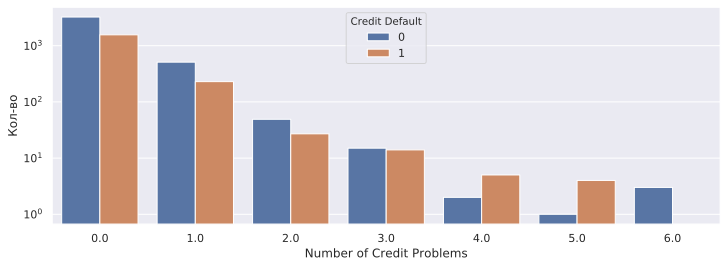

In [79]:
cat_plot(train_df,'Number of Credit Problems',x = True, log_y=True)

In [80]:
chi2_cat_to_cat(train_df,'Number of Credit Problems', 30, all_info = True)

0.0    -    1.0
Среднее chi2 равно: 0.8731343350516286
Среднее p-value равно: 0.5719626214340718
Установленный нами порог α = 0,05
-------------------------------------------
0.0    -    3.0
Среднее chi2 равно: 0.541722695185207
Среднее p-value равно: 0.6351969028010294
Установленный нами порог α = 0,05
-------------------------------------------
0.0    -    2.0
Среднее chi2 равно: 0.6147983509984348
Среднее p-value равно: 0.5740900946810696
Установленный нами порог α = 0,05
-------------------------------------------
0.0    -    6.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
0.0    -    4.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
0.0    -    5.0
Среднее chi2 равно: 0.02015087971184242
Среднее p-value равно: 0.9755827893881572
Установленный нами порог α = 0,05
-------------------------------------------
1.0    -  

Тут все по такой же схеме, как в предыдущем

## Финальное преобразование признаков

### Приведение типов

In [81]:
cat_colls = ['Home Ownership','Purpose']
for coll in cat_colls:
    train_df[coll] = pd.Categorical(train_df[coll])

## Преобразование категориальных данных в бинарные и сохранение датасетов

In [82]:
colls = ['Home Ownership','Purpose']
train_df = train_df.replace('Short Term',0)
train_df = train_df.replace('Long Term',1)
train_final = pd.get_dummies(train_df,columns = colls)
train_final.rename(columns = {'Years in current job_< 1 year' : 'Years in current job less 1 year',
                          'Years in current job_10+ years' : 'Years in current job more 10 years'}, inplace=True)
train_final.to_csv("train_dummies.csv", index=False)
train_df.to_csv("train_prepared.csv", index = False)

Сконтатенируем наши категориальные признаки по раннее сделанному анализу

### Home Ownership

In [83]:
train_final['Home Ownership_2'] = train_final['Home Ownership_Have Mortgage']
train_final['Home Ownership_1'] = [a + b + c for a,b,c in zip(train_final['Home Ownership_Home Mortgage'], 
                                                              train_final['Home Ownership_Own Home'],
                                                              train_final['Home Ownership_Rent']
                                                             )]

### Purpose

In [84]:
train_final['Purpose_1'] = train_final['Purpose_wedding']
train_final['Purpose_2'] = [a + b + c + d for a,b,c,d in zip(train_final['Purpose_vacation'],
                                                             train_final['Purpose_educational expenses'],
                                                             train_final['Purpose_moving'],
                                                             train_final['Purpose_buy house']
                                                             )]
train_final['Purpose_3'] = [q+w+e+r+t+y+u+i+o for q,w,e,r,t,y,u,i,o in zip(train_final['Purpose_debt consolidation'],
                                                                          train_final['Purpose_other'],
                                                                          train_final['Purpose_home improvements'],
                                                                          train_final['Purpose_take a trip'],
                                                                          train_final['Purpose_buy a car'],
                                                                          train_final['Purpose_small business'],
                                                                          train_final['Purpose_business loan'],
                                                                          train_final['Purpose_medical bills'],
                                                                          train_final['Purpose_major purchase'])]

In [85]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5653 entries, 1 to 7499
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 5653 non-null   float64
 1   Years in current job          5653 non-null   int64  
 2   Tax Liens                     5653 non-null   float64
 3   Number of Open Accounts       5653 non-null   float64
 4   Years of Credit History       5653 non-null   float64
 5   Maximum Open Credit           5653 non-null   float64
 6   Number of Credit Problems     5653 non-null   float64
 7   Bankruptcies                  5653 non-null   float64
 8   Term                          5653 non-null   int64  
 9   Current Loan Amount           5653 non-null   float64
 10  Current Credit Balance        5653 non-null   float64
 11  Monthly Debt                  5653 non-null   float64
 12  Credit Default                5653 non-null   int64  
 13  Id 

In [86]:
train_final.drop(['Purpose_vacation','Purpose_buy a car','Purpose_buy house','Purpose_debt consolidation',
                  'Purpose_educational expenses','Purpose_home improvements','Purpose_major purchase',
                 'Purpose_medical bills','Purpose_moving','Purpose_other','Purpose_small business','Purpose_take a trip',
                 'Purpose_vacation','Purpose_wedding','Purpose_business loan','Home Ownership_Have Mortgage','Home Ownership_Home Mortgage',
                 'Home Ownership_Own Home','Home Ownership_Rent'], axis = 1, inplace = True)

In [87]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5653 entries, 1 to 7499
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Annual Income              5653 non-null   float64
 1   Years in current job       5653 non-null   int64  
 2   Tax Liens                  5653 non-null   float64
 3   Number of Open Accounts    5653 non-null   float64
 4   Years of Credit History    5653 non-null   float64
 5   Maximum Open Credit        5653 non-null   float64
 6   Number of Credit Problems  5653 non-null   float64
 7   Bankruptcies               5653 non-null   float64
 8   Term                       5653 non-null   int64  
 9   Current Loan Amount        5653 non-null   float64
 10  Current Credit Balance     5653 non-null   float64
 11  Monthly Debt               5653 non-null   float64
 12  Credit Default             5653 non-null   int64  
 13  Id                         5653 non-null   int64

## Приведение типов

In [88]:
NUM_FEATURES = ['Annual Income','Number of Open Accounts','Bankruptcies','Years of Credit History','Maximum Open Credit',
               'Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score','Tax Liens','Number of Credit Problems']
CAT_FEATURES = ['Home Ownership_1','Home Ownership_2','Purpose_1','Purpose_2','Purpose_3',]

for dig_col in NUM_FEATURES:
    train_final[NUM_FEATURES] = train_final[NUM_FEATURES].astype('int64')

for cat_col in CAT_FEATURES:
    train_final[cat_col] = pd.Categorical(train_final[cat_col])


In [89]:
train_final.dtypes

Annual Income                   int64
Years in current job            int64
Tax Liens                       int64
Number of Open Accounts         int64
Years of Credit History         int64
Maximum Open Credit             int64
Number of Credit Problems       int64
Bankruptcies                    int64
Term                            int64
Current Loan Amount             int64
Current Credit Balance          int64
Monthly Debt                    int64
Credit Default                  int64
Id                              int64
Credit Score                    int64
Home Ownership_2             category
Home Ownership_1             category
Purpose_1                    category
Purpose_2                    category
Purpose_3                    category
dtype: object

Сохраним датасет

In [90]:
train_final.to_csv("train_dummies_prepared.csv", index=False)